In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata #need to use pip install sodapy to get this, using it to get data from the CDC website
import os
import numpy as np
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, ParameterSampler
import optuna

data_prefix = 'Data/'
output_prefix_01 = '01_data_processing.ipynb.output/'

## Getting Data

In [5]:
#make a Data folder if one doesn't exist
if not os.path.exists(data_prefix):
    os.makedirs(data_prefix)

#check if the data files exist, otherwise pull from the CDC website
if not os.path.exists(data_prefix + 'covid_rates.csv'):
    print('Downloading data from CDC website')
    ## pulling data from CDC website using Socrata API
    # Create a client object
    client = Socrata("data.cdc.gov", None)

    # pull rsv, covid, and flu rates data https://data.cdc.gov/Public-Health-Surveillance/Rates-of-Laboratory-Confirmed-RSV-COVID-19-and-Flu/kvib-3txy/about_data
    covid_rates_results = client.get("kvib-3txy",limit=47333)
    # Convert to pandas DataFrame
    covid_rates_df = pd.DataFrame.from_records(covid_rates_results)
    #pull youth obesity data https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Youth-Risk/vba9-s8jp/about_data
    youth_results = client.get("vba9-s8jp", limit=50092)
    # Convert to pandas DataFrame
    youth_df = pd.DataFrame.from_records(youth_results)
    #pull adult obesity data https://chronicdata.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7/about_data
    adult_results = client.get("hn4x-zwk7", limit=104272)
    # Convert to pandas DataFrame
    adult_df = pd.DataFrame.from_records(adult_results)

    #download the data into the data folder
    covid_rates_df.to_csv(data_prefix + 'covid_rates.csv', index=False)
    youth_df.to_csv(data_prefix + 'youth_obesity.csv', index=False)
    adult_df.to_csv(data_prefix + 'adult_obesity.csv', index=False)
else:
    print('Data already downloaded')
    #read in the data
    covid_rates_df = pd.read_csv(data_prefix + 'covid_rates.csv')
    adult_df = pd.read_csv(data_prefix + 'adult_obesity.csv')


Data already downloaded


In [6]:
#arrange the data by mmwr_year and then by mmwr_week
covid_rates_df = covid_rates_df.sort_values(by=['mmwr_year', 'mmwr_week'])

#keep only the unadjusted rates
covid_rates_df = covid_rates_df[covid_rates_df['type'] == 'Unadjusted Rate']
#keep only the Combined surveillance data
covid_rates_df = covid_rates_df[covid_rates_df['surveillance_network'] == 'Combined']


#remove the surveillance_network, season, cumulative, _weekddate, and type columns
covid_rates_df = covid_rates_df.drop(columns=['surveillance_network', 'season', 'cumulative_rate', '_weekenddate', 'type'])
covid_rates_df

,mmwr_year,mmwr_week,age_group,sex,race_ethnicity,site,weekly_rate
34836,2018.0,40.0,40-49 yr,Overall,Overall,Overall,0.1
36421,2018.0,40.0,75-84 yr,Overall,Overall,Overall,0.3
36452,2018.0,40.0,Overall,Overall,"American Indian/Alaska Native, NH",Overall,0.0
36483,2018.0,40.0,Adults,Overall,Overall,Overall,0.1
36514,2018.0,40.0,85+ yr,Overall,Overall,Overall,0.2
...,...,...,...,...,...,...,...
44069,2025.0,14.0,Overall,Overall,Overall,California,1.1
46296,2025.0,14.0,5-11 yr,Overall,Overall,Overall,1.4
46323,2025.0,14.0,Adults,Overall,Overall,Overall,2.9
46480,2025.0,14.0,Overall,Overall,Overall,Ohio,0.9


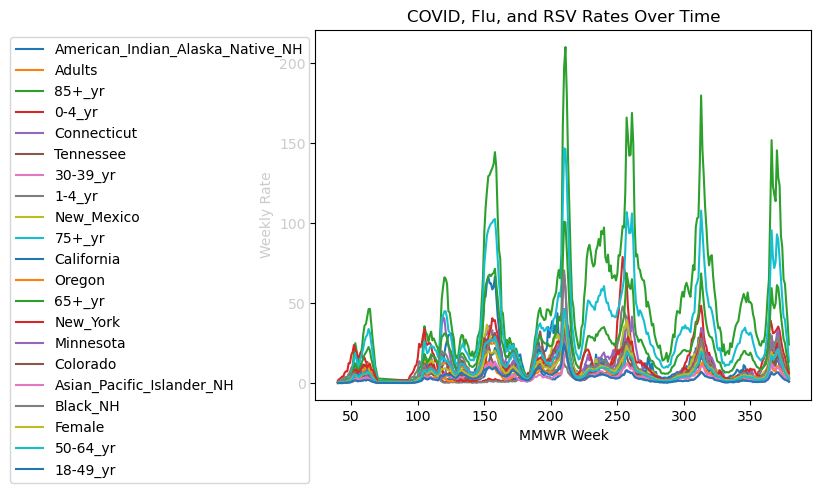

In [7]:
#pivot wider on the mmwr_year and mmwr_week columns
covid_rates_df_wide = covid_rates_df.pivot(index=['mmwr_year', 'mmwr_week'], columns=["age_group", "sex", "race_ethnicity", "site"], values='weekly_rate').reset_index()
covid_rates_df_wide

#squeeze the columns
covid_rates_df_wide.columns = ['_'.join(map(str, col)).replace(' ', '_') for col in covid_rates_df_wide.columns.values]
# replace the 'Overall_Overall_Overall_Overall' with 'all'
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('Overall_Overall_Overall_Overall', 'All')
#remove "Overall" from the column names
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('Overall', '')
#remove the leading and trailing underscores
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.strip('_')
#replace any , or / with _
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace(',', '_')
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('/', '_')
#replace any double _ with _
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('__', '_')
#remove any columns with nas
covid_rates_df_wide = covid_rates_df_wide.dropna(axis=1, how='any')
#save the data to a csv file
covid_rates_df_wide.to_csv(output_prefix_01 + 'disease_rates_wide.csv', index=False)

#replace the mmwr_year with a multiple of 52 (53 for year 2020), starting at 2018 = 0, all the way to 2025
covid_rates_df_wide['mmwr_year'] = covid_rates_df_wide['mmwr_year'].replace({2018: 0, 2019: 52, 2020: 104, 2021: 157, 2022: 209, 2023: 261, 2024: 313, 2025: 365})
#add the mmwr_week to the mmwr_year
covid_rates_df_wide['mmwr_week'] = covid_rates_df_wide['mmwr_year'] + covid_rates_df_wide['mmwr_week']
#remove the mmwr_year column
covid_rates_df_wide = covid_rates_df_wide.drop(columns=['mmwr_year'])
#plot the data over mmwr_week for All
# plt.plot(covid_rates_df_wide['mmwr_week'], covid_rates_df_wide['All'])
# plt.title('COVID, Flu, and RSV Rates Over Time')
# plt.xlabel('MMWR Week')
# plt.ylabel('Weekly Rate')
# plt.show()

#save the data to a csv file
covid_rates_df_wide.to_csv(output_prefix_01 + 'disease_rates_wide.csv', index=False)
#iterate throught the columns and plot each one on the same graph
for col in covid_rates_df_wide.columns:
    if col != 'mmwr_week':
        plt.plot(covid_rates_df_wide['mmwr_week'], covid_rates_df_wide[col], label=col)
plt.title('COVID, Flu, and RSV Rates Over Time')
plt.xlabel('MMWR Week')
plt.ylabel('Weekly Rate')
#move the legend outside of the plot
plt.legend(loc='upper right', bbox_to_anchor=(0, 1))
plt.show()


In [8]:
# covid_rates_df["type"].value_counts() 

## Data Processing

In [9]:
#transform adult dataframe
#pivotting the dataframe so that each row for a given year and location, and each column is the average value for different demographics for that metric
adult_df_very_wide = adult_df.pivot_table(index=['yearstart','locationabbr','geolocation'],columns=['class',"stratificationid1"],values="data_value")
#change the index to columns
adult_df_very_wide.reset_index(inplace=True)
#smoosh the column index
adult_df_very_wide.columns = ['_'.join(col).strip() for col in adult_df_very_wide.columns.values]
#replace whitespace with underscores
adult_df_very_wide.columns = adult_df_very_wide.columns.str.replace(' ', '')
#remove trailing underscores
adult_df_very_wide.columns = adult_df_very_wide.columns.str.rstrip('_')
#add a prefix 'Adult' to all columns except for the first three
adult_df_very_wide.columns = ['adult_' + col if col not in ['yearstart','locationabbr','geolocation'] else col for col in adult_df_very_wide.columns]
#split the data in the geolocation column into two columns, 'latitude' and 'longitude', I tried doing this by transforming the dictionaries in this column but couldn't figure it out
#the geolocation column is a string that starts like this: "{'latitude': '37.7749', 'longitude': '-122.4194'}"
adult_df_very_wide["latitude"] = adult_df_very_wide['geolocation'].str.split(',', expand=True)[0].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
adult_df_very_wide["longitude"] = adult_df_very_wide['geolocation'].str.split(',', expand=True)[1].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
#drop the geolocation column
adult_df_very_wide.drop(columns=['geolocation'], inplace=True)

#move the latitude and longitude columns to the front
cols = adult_df_very_wide.columns.tolist()
cols = cols[-2:] + cols[:-2]
adult_df_very_wide = adult_df_very_wide[cols]

adult_df_very_wide.columns = adult_df_very_wide.columns.str.replace('/', '')



In [10]:
print(adult_df_very_wide.shape)
#remove rows with nas in adult_ObesityWeightStatus_OVERALL
adult_df_very_wide.dropna(subset=['adult_ObesityWeightStatus_OVERALL'], inplace=True)
print(adult_df_very_wide.shape)
#remove columns with all na
adult_df_very_wide.dropna(axis=1, how='all', inplace=True)
print(adult_df_very_wide.shape)
#remove columns that are derived from the adult_ObesityWeightStatus_OVERALL column
adult_obesity_cols = [col for col in adult_df_very_wide.columns if col.startswith('adult_ObesityWeightStatus') and col != 'adult_ObesityWeightStatus_OVERALL']
adult_df_very_wide.drop(columns=adult_obesity_cols, inplace=True)
print(adult_df_very_wide.shape)
#remove locations with less than 7 data points (7 time points from 2011-2023)
location_counts = adult_df_very_wide['locationabbr'].value_counts()
locations_to_remove = location_counts[location_counts < 7].index.tolist()
adult_df_very_wide = adult_df_very_wide[~adult_df_very_wide['locationabbr'].isin(locations_to_remove)]
print(adult_df_very_wide.shape)



(684, 88)
(684, 88)
(684, 88)
(684, 61)
(680, 61)


In [11]:
print(adult_df_very_wide.isna().sum().sum())
#calculate column means grouped by location
group_means = adult_df_very_wide.groupby('locationabbr').mean()
#fill missing values with the mean of the column, matching locationabbr
for location in group_means.index:
    for col in group_means.columns:
        #check if the location is in the dataframe
        if location in adult_df_very_wide['locationabbr'].values:
            #check if the column is in the dataframe
            if col in adult_df_very_wide.columns:
                #fill missing values with the mean of the column
                adult_df_very_wide.loc[adult_df_very_wide['locationabbr'] == location, col] = adult_df_very_wide.loc[adult_df_very_wide['locationabbr'] == location, col].fillna(group_means.loc[location, col])
print(adult_df_very_wide.isna().sum().sum())
#impute the final missing values with the mean of the column except for the first 4 columns
adult_df_very_wide.iloc[:, 4:] = adult_df_very_wide.iloc[:, 4:].fillna(adult_df_very_wide.iloc[:, 4:].mean())
print(adult_df_very_wide.isna().sum().sum())


16815
2464
0


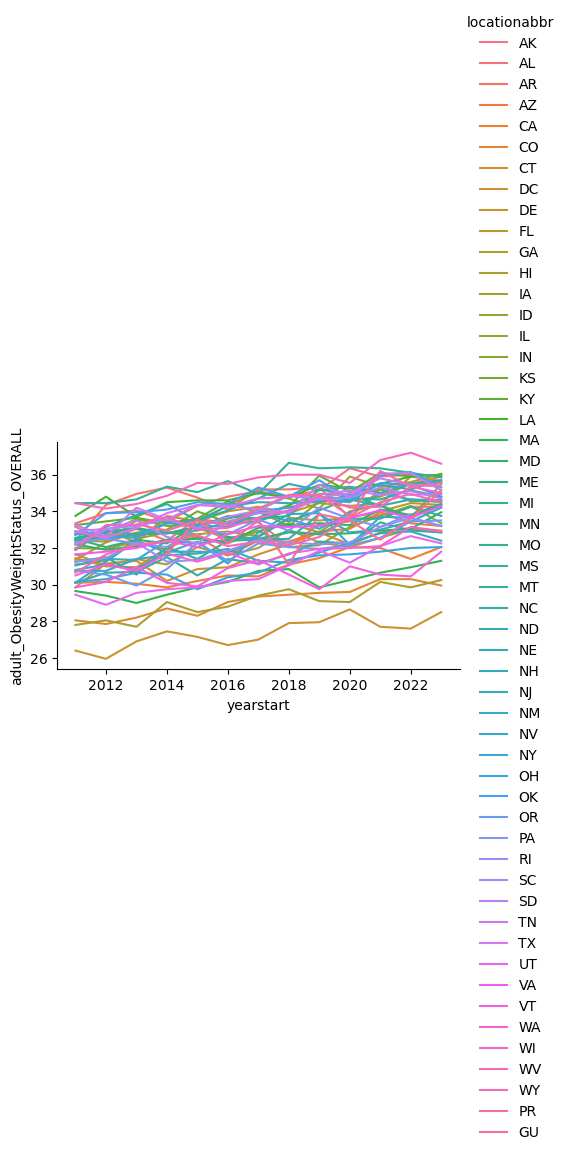

In [12]:
#plot a scatterplot of the adult obesity data over year colored by state
fg = sns.FacetGrid(data=adult_df_very_wide, hue='locationabbr', aspect=1.61)
fg.map(plt.plot, 'yearstart', 'adult_ObesityWeightStatus_OVERALL').add_legend()

In [13]:
#if output folder doesn't exist, make it
if not os.path.exists(output_prefix_01):
    os.makedirs(output_prefix_01)
#outputting the data to a csv file
adult_df_very_wide.to_csv(output_prefix_01+'data.csv', index=False)

In [14]:
adult_df_very_wide['yearstart'].max()

2023

## **EDA Statistics and Visualizations**

In [51]:
print(adult_df_very_wide.info())

<class 'pandas.core.frame.DataFrame'>
Index: 680 entries, 0 to 682
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   latitude                               680 non-null    float64
 1   longitude                              680 non-null    float64
 2   yearstart                              680 non-null    int64  
 3   locationabbr                           680 non-null    object 
 4   adult_FruitsandVegetables_AGEYR1824    680 non-null    float64
 5   adult_FruitsandVegetables_AGEYR2534    680 non-null    float64
 6   adult_FruitsandVegetables_AGEYR3544    680 non-null    float64
 7   adult_FruitsandVegetables_AGEYR4554    680 non-null    float64
 8   adult_FruitsandVegetables_AGEYR5564    680 non-null    float64
 9   adult_FruitsandVegetables_AGEYR65PLUS  680 non-null    float64
 10  adult_FruitsandVegetables_EDUCOGRAD    680 non-null    float64
 11  adult_Fruit

In [52]:
print(adult_df_very_wide.describe()) #Print to evaluate metrics of data features

         latitude   longitude    yearstart  \
count  680.000000  680.000000   680.000000   
mean    38.976072  -89.530466  2017.011765   
std      7.404668   34.317194     3.723884   
min     13.444304 -157.857749  2011.000000   
25%     35.466221 -100.373531  2014.000000   
50%     39.360700  -88.997710  2017.000000   
75%     43.235541  -77.860700  2020.000000   
max     64.845080  144.793731  2023.000000   

       adult_FruitsandVegetables_AGEYR1824  \
count                           680.000000   
mean                             35.078456   
std                               3.731646   
min                              24.100000   
25%                              33.600000   
50%                              34.783333   
75%                              36.537500   
max                              56.500000   

       adult_FruitsandVegetables_AGEYR2534  \
count                           680.000000   
mean                             30.853137   
std                             

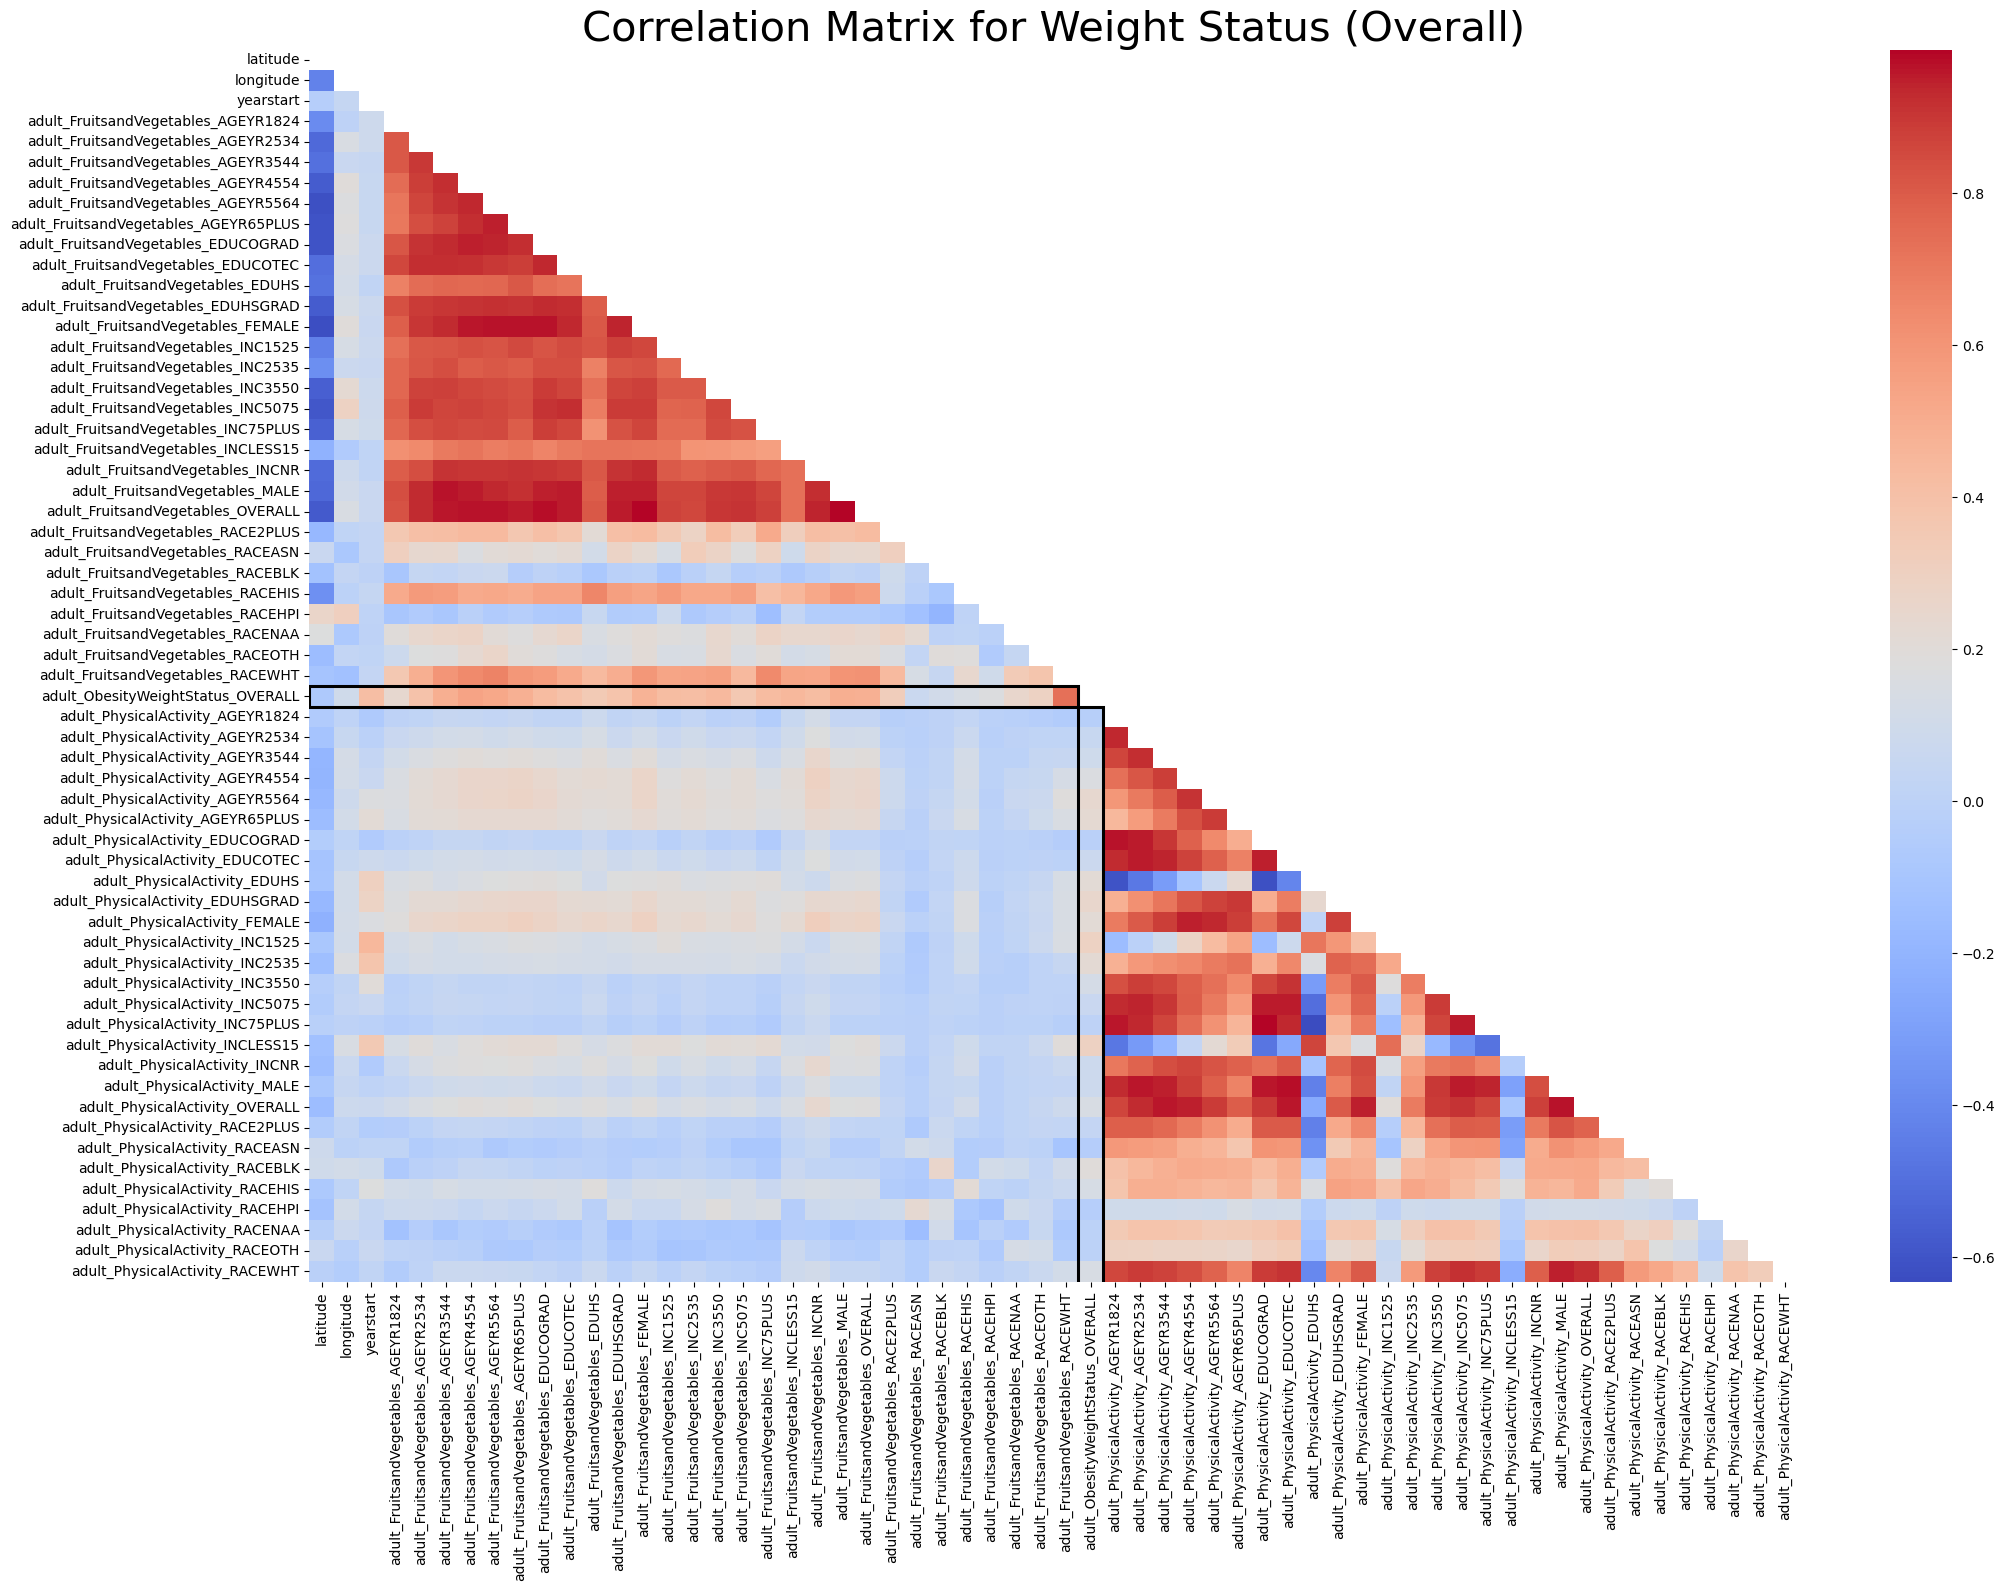

In [53]:
# Calculate the correlation matrix
#Removing location column since non-numerical
corr_matrix_df = adult_df_very_wide.drop(columns=['locationabbr'])
corr_matrix = corr_matrix_df.corr()

# Target variable to highlight
target_col = 'adult_ObesityWeightStatus_OVERALL'
target_col_idx = corr_matrix.columns.get_loc(target_col)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap of the correlation matrix with the mask
plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', mask=mask)

#Highlight border of the target variable
rect_horiz = Rectangle((target_col_idx, target_col_idx), -31, 1, fill=False, edgecolor='black', linewidth=2.2)
plt.gca().add_patch(rect_horiz)

rect_vert = Rectangle((target_col_idx, target_col_idx + 1), 1, 31, fill=False, edgecolor='black', linewidth=2.2)
plt.gca().add_patch(rect_vert)

plt.title('Correlation Matrix for Weight Status (Overall)', fontsize=30)
plt.show()


#### Here we want to look at correlation between the other numerical target features and output weight status. We see that fruit and vegetable intake seems to have a higher correlation than adult physical activity values. There also seems to be potential multicollinearity between 'physical activity values' and 'fruits_vegetables' values

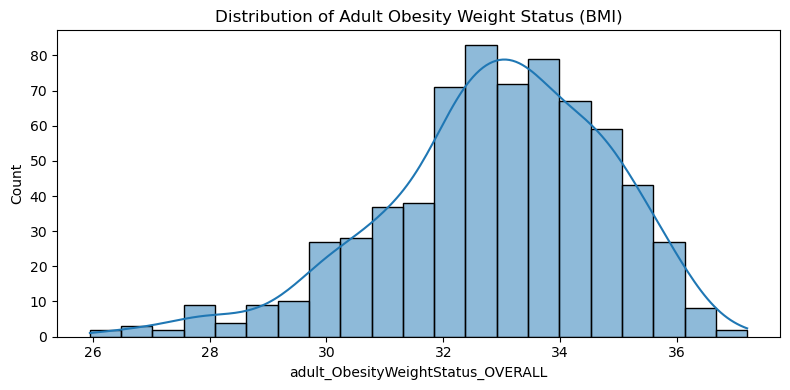

In [54]:
plt.figure(figsize=(8, 4))

sns.histplot(adult_df_very_wide['adult_ObesityWeightStatus_OVERALL'], kde=True)
plt.title("Distribution of Adult Obesity Weight Status (BMI)")
plt.tight_layout()
plt.show()

In [55]:
bmi_average = adult_df_very_wide['adult_ObesityWeightStatus_OVERALL'].mean()
bmi_min = adult_df_very_wide['adult_ObesityWeightStatus_OVERALL'].min()
bmi_max = adult_df_very_wide['adult_ObesityWeightStatus_OVERALL'].max()

print(f"The average BMI is: {bmi_average} \nThe minimum BMI is {bmi_min} \nThe maximum BMI is {bmi_max}")

The average BMI is: 32.88985294117647 
The minimum BMI is 25.95 
The maximum BMI is 37.2


#### We want to look at the distribution of BMI outcome data to get an idea of the data distribution. The average BMI is ~33, minimum is 25.95, and max is 37.2. 

## **Splitting Dataset**

In [56]:
#Input features X
X = adult_df_very_wide.drop(columns=['adult_ObesityWeightStatus_OVERALL', 'locationabbr'])

#Output of weight status BMI
y = adult_df_very_wide['adult_ObesityWeightStatus_OVERALL']

In [58]:
# Split into training and rest of temporary data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:",X_test.shape, y_test.shape)

Training set shape: (544, 59) (544,)
Testing set shape: (136, 59) (136,)


## **Baseline Model - Ridge Regression Model**

#### Making a pipeline for our baseline regression model. We are standardizing the input features, and using a Ridge regression model to use as a baseline model. We chose Ridge regression due to many of the input features potentially having multicollinearity, and to help to reduce variance. 

#### Model Pipeline

In [59]:
linear_model_pipe = make_pipeline(
    StandardScaler(),
    Ridge(alpha=0.1)
)

ridge_reg = linear_model_pipe.fit(X_train, y_train)
ridge_reg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.1))])

#### K-Fold Cross Validation

In [60]:
best_cv = 0
best_mean_accuracy = 0

ridge_reg_cv = Ridge(random_state=5, max_iter=1000) #Import Classifer

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(ridge_reg_cv, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.7625888657735247
CV: 3, Mean accuracy: 0.7936757372104098
CV: 4, Mean accuracy: 0.7899556994340364
CV: 5, Mean accuracy: 0.789145432765318
CV: 6, Mean accuracy: 0.7973617124057325
CV: 7, Mean accuracy: 0.7973722517490993
CV: 8, Mean accuracy: 0.7948336020260383
CV: 9, Mean accuracy: 0.7935174183853222
CV: 10, Mean accuracy: 0.7945814162478725
Best CV value: 7 with mean accuracy: 0.7973722517490993


#### Optuna

In [61]:
linear_model_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('ridge', Ridge(alpha=0.1))],
 'transform_input': None,
 'verbose': False,
 'standardscaler': StandardScaler(),
 'ridge': Ridge(alpha=0.1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'ridge__alpha': 0.1,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

In [ ]:
# Optuna (Ridge Regression Classifier)
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 5000)

    ridge_reg = Ridge(
        random_state=22,
        alpha=alpha,
        max_iter=max_iter,
        solver=solver
    )
    
    best_score = cross_val_score(ridge_reg, X_train, y_train, cv=cv)
    return best_score.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=22))
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")

# Fit the ridge_reg model with the best Optuna hyperparameters
best_params = study.best_trial.params
ridge_reg_best_optuna = Ridge(
    random_state=22,
    alpha=best_params['alpha'],
    max_iter=best_params['max_iter'],
    solver=best_params['solver']
)
ridge_reg_best_optuna = ridge_reg_best_optuna.fit(X_train, y_train)

[I 2025-04-21 19:48:05,551] A new study created in memory with name: no-name-f78b27de-0c38-4ab8-9362-f1e769ef31aa
[I 2025-04-21 19:48:05,593] Trial 0 finished with value: 0.794430395568386 and parameters: {'alpha': 0.042206720857789606, 'solver': 'cholesky', 'max_iter': 1180}. Best is trial 0 with value: 0.794430395568386.
[I 2025-04-21 19:48:05,630] Trial 1 finished with value: 0.7942141622684888 and parameters: {'alpha': 2.7280527372678933, 'solver': 'cholesky', 'max_iter': 4794}. Best is trial 0 with value: 0.794430395568386.
[I 2025-04-21 19:48:05,691] Trial 2 finished with value: 0.7945107508065362 and parameters: {'alpha': 1.2758912300503147, 'solver': 'svd', 'max_iter': 3543}. Best is trial 2 with value: 0.7945107508065362.
[I 2025-04-21 19:48:05,751] Trial 3 finished with value: 0.7943561095144742 and parameters: {'alpha': 0.021661349799972935, 'solver': 'svd', 'max_iter': 3750}. Best is trial 2 with value: 0.7945107508065362.
[I 2025-04-21 19:48:05,788] Trial 4 finished with v

Best trial: {'alpha': 0.3511400360330465, 'solver': 'svd', 'max_iter': 3851}


#### Testing and Results

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = ridge_reg_best_optuna.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2   = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R-squared:   {r2:.3f}")


MAE:  0.635
RMSE: 0.794
R-squared:   0.833


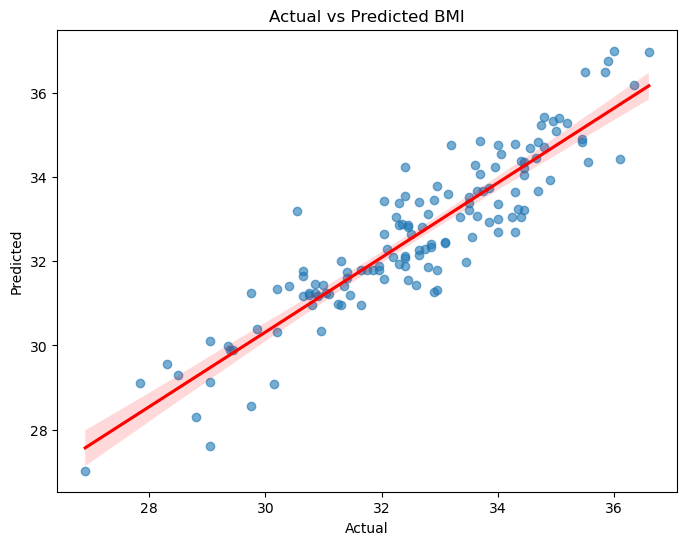

In [64]:
#Plot regression line between actual vs predicted 

plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted BMI")
plt.show()


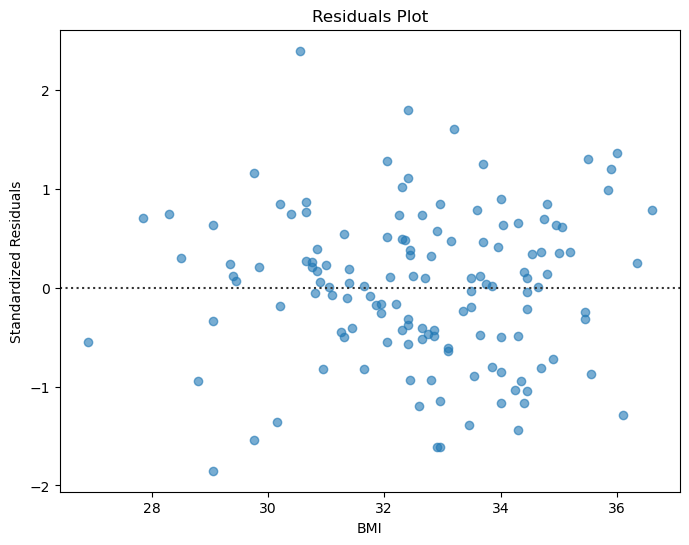

In [65]:
#Plot residuals between actual vs predicted 

plt.figure(figsize=(8, 6))
sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.6})
plt.xlabel("BMI")
plt.ylabel("Standardized Residuals")
plt.title("Residuals Plot")
plt.show()


## **Deep Learning Model - Feedforward Fully Connected Network**

In [2]:
import torch
import torch.nn as nn
import lightning as L
from torch.utils.data import random_split, DataLoader, TensorDataset
from torchinfo import summary
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score, Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger


#### Convert Data to Tensors and Splitting Data

In [16]:
#Input features X
X = adult_df_very_wide.drop(columns=['adult_ObesityWeightStatus_OVERALL', 'locationabbr'])

#Output of weight status BMI  
y = adult_df_very_wide['adult_ObesityWeightStatus_OVERALL']

In [17]:
# Split into training and rest of temporary data split
X_train_df, X_temp, y_train_df, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split rest of data into validation and test sets
X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train_df.shape, y_train_df.shape)
print("Validation set shape:", X_val_df.shape, y_val_df.shape)
print("Testing set shape:",X_test_df.shape, y_test_df.shape)

Training set shape: (544, 59) (544,)
Validation set shape: (68, 59) (68,)
Testing set shape: (68, 59) (68,)


In [18]:
# Fit scaler on train, apply to all splits
scaler = StandardScaler().fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_val   = scaler.transform(X_val_df)
X_test  = scaler.transform(X_test_df)

y_scaler = StandardScaler().fit(y_train_df.values.reshape(-1, 1))

y_train = y_scaler.transform(y_train_df.values.reshape(-1, 1))
y_val   = y_scaler.transform(y_val_df.values.reshape(-1, 1))
y_test  = y_scaler.transform(y_test_df.values.reshape(-1, 1))

In [19]:
#Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



#Split into training, validation, and test datasets
ds_train, ds_val, ds_test =(
    TensorDataset(X_train_tensor, y_train_tensor),
    TensorDataset(X_val_tensor, y_val_tensor),
    TensorDataset(X_test_tensor, y_test_tensor)
)

#DataLoaders
train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=32, shuffle=False)
test_loader = DataLoader(ds_test, batch_size=32, shuffle=False)

In [20]:
len(ds_train), len(ds_val), len(ds_test)

(544, 68, 68)

#### Create Model

In [21]:
class RegressionBaseModule(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr

        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

        self.train_r2 = R2Score()
        self.val_r2 = R2Score()
        self.test_r2 = R2Score()

    def _common_step(self, batch, batch_idx, mae_metric, r2_metric, loss_lbl, mae_lbl, r2_lbl):
        X, y = batch
        y_hat = self(X).squeeze()
        y_hat = y_hat.view(-1, 1)  # Reshape y_hat to [batch_size, 1]
        loss = nn.functional.mse_loss(y_hat, y)
        
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(mae_lbl, mae_metric(y_hat, y), prog_bar=True)
        self.log(r2_lbl, r2_metric(y_hat, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_mae, self.train_r2, "train_loss", "train_mae", "train_r2")

    def on_training_epoch_end(self):
        self.log("train_mae_epoch", self.train_mae.compute())
        self.log("train_r2_epoch", self.train_r2.compute())
        self.train_mae.reset()
        self.train_r2.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mae, self.val_r2, "val_loss", "val_mae", "val_r2")

    def on_validation_epoch_end(self):
        self.log("val_mae_epoch", self.val_mae.compute())
        self.log("val_r2_epoch", self.val_r2.compute())
        self.val_mae.reset()
        self.val_r2.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_mae, self.test_r2, "test_loss", "test_mae", "test_r2")

    def on_test_epoch_end(self):
        self.log("test_mae_epoch", self.test_mae.compute())
        self.log("test_r2_epoch", self.test_r2.compute())
        self.test_mae.reset()
        self.test_r2.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [ ]:
class FFCN_Obesity_Model(RegressionBaseModule):
    def __init__(self, input_dim, hidden_dim=32, lr=0.001):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

#### Tuning Hyperparameters (Optuna)

In [27]:
callbacks = [
    ModelCheckpoint(
        monitor='val_loss',     # Metric to monitor for saving the best model
        mode='min',             # Indicate a minimization process
        save_last=True,         # Save the last checkpoint (useful for resuming training)
        save_top_k=1,           # Save the top k models based on the monitored metric
        dirpath='checkpoints/', # Directory to save the checkpoints to
        filename='model-{epoch:02d}-{val_loss:.2f}',  # Name of saved checkpoints
    ),
    EarlyStopping(
        monitor='val_loss',     # Metric to monitor for early stopping
        patience=4,             # How many epochs with no improvement before training is stopped
        mode='min',             # Indicate a minimization process
    )
]

logger = CSVLogger("logs", name='fc_obesity_model_v1_0')

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 32, 512)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model = FFCN_Obesity_Model(input_dim=59, hidden_dim=hidden_dim, lr=learning_rate)

    trainer = L.Trainer(
        max_epochs=50,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        logger=logger,
        callbacks=callbacks
    )

    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    val_loss = trainer.callback_metrics["val_loss"].item()

    return val_loss

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=22))
study.optimize(objective, n_trials=50)

[I 2025-04-21 22:10:44,833] A new study created in memory with name: no-name-29f18a06-c7dd-402a-9a9f-10621e8bdb34
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 25.6 K | train
--------------------------------------------------------
25.6 K    Trainable params
0         Non-trainable params
25.6 K    To

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 97.44it/s, v_num=14, train_loss=0.894, train_mae=0.701, train_r2=0.138, val_loss=0.558, val_mae=0.585, val_r2=0.473]


[I 2025-04-21 22:10:45,087] Trial 0 finished with value: 0.5583910942077637 and parameters: {'hidden_dim': 132, 'lr': 0.00027863982281787103}. Best is trial 0 with value: 0.5583910942077637.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 69.3 K | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 125.92it/s, v_num=14, train_loss=0.391, train_mae=0.538, train_r2=0.495, val_loss=0.373, val_mae=0.468, val_r2=0.648]


[I 2025-04-21 22:10:45,265] Trial 1 finished with value: 0.3734111189842224 and parameters: {'hidden_dim': 234, 'lr': 0.00378047173666408}. Best is trial 1 with value: 0.3734111189842224.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 20.1 K | train
-----------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 133.45it/s, v_num=14, train_loss=0.593, train_mae=0.631, train_r2=0.220, val_loss=0.637, val_mae=0.628, val_r2=0.408]


[I 2025-04-21 22:10:45,436] Trial 2 finished with value: 0.6372438073158264 and parameters: {'hidden_dim': 114, 'lr': 0.00010389433839450859}. Best is trial 1 with value: 0.3734111189842224.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 36.3 K | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 131.89it/s, v_num=14, train_loss=0.436, train_mae=0.509, train_r2=0.587, val_loss=0.466, val_mae=0.537, val_r2=0.581]


[I 2025-04-21 22:10:45,609] Trial 3 finished with value: 0.46581539511680603 and parameters: {'hidden_dim': 162, 'lr': 0.001183379526545995}. Best is trial 1 with value: 0.3734111189842224.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 27.6 K | train
---------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 132.08it/s, v_num=14, train_loss=0.648, train_mae=0.662, train_r2=0.293, val_loss=0.549, val_mae=0.571, val_r2=0.487]


[I 2025-04-21 22:10:45,781] Trial 4 finished with value: 0.5493119359016418 and parameters: {'hidden_dim': 138, 'lr': 0.0027280527372678938}. Best is trial 1 with value: 0.3734111189842224.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 3.7 K  | train
---------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 134.68it/s, v_num=14, train_loss=0.740, train_mae=0.681, train_r2=0.248, val_loss=0.917, val_mae=0.746, val_r2=0.176]


[I 2025-04-21 22:10:45,951] Trial 5 finished with value: 0.9166677594184875 and parameters: {'hidden_dim': 37, 'lr': 0.00048262641728723325}. Best is trial 1 with value: 0.3734111189842224.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 205 K  | train
---------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 122.31it/s, v_num=14, train_loss=0.360, train_mae=0.473, train_r2=0.636, val_loss=0.325, val_mae=0.450, val_r2=0.698]

[I 2025-04-21 22:10:46,168] Trial 6 finished with value: 0.3248984217643738 and parameters: {'hidden_dim': 423, 'lr': 0.001719099001922072}. Best is trial 6 with value: 0.3248984217643738.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 22.4 K | train
----------------------------------------------------


Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 132.61it/s, v_num=14, train_loss=0.615, train_mae=0.602, train_r2=0.515, val_loss=0.585, val_mae=0.600, val_r2=0.469]


[I 2025-04-21 22:10:46,341] Trial 7 finished with value: 0.5853379368782043 and parameters: {'hidden_dim': 122, 'lr': 1.0433321710980318e-05}. Best is trial 6 with value: 0.3248984217643738.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 187 K  | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 117.91it/s, v_num=14, train_loss=0.460, train_mae=0.547, train_r2=0.648, val_loss=0.295, val_mae=0.426, val_r2=0.740]


[I 2025-04-21 22:10:46,529] Trial 8 finished with value: 0.2953965663909912 and parameters: {'hidden_dim': 403, 'lr': 0.007473026189839368}. Best is trial 8 with value: 0.2953965663909912.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 159 K  | train
----------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 122.74it/s, v_num=14, train_loss=0.207, train_mae=0.346, train_r2=0.569, val_loss=0.345, val_mae=0.453, val_r2=0.683]


[I 2025-04-21 22:10:46,711] Trial 9 finished with value: 0.34490281343460083 and parameters: {'hidden_dim': 369, 'lr': 7.811506538053162e-05}. Best is trial 8 with value: 0.2953965663909912.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 289 K  | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 114.85it/s, v_num=14, train_loss=0.335, train_mae=0.456, train_r2=0.652, val_loss=0.290, val_mae=0.420, val_r2=0.728]


[I 2025-04-21 22:10:46,912] Trial 10 finished with value: 0.2904137670993805 and parameters: {'hidden_dim': 508, 'lr': 0.009972072003500518}. Best is trial 10 with value: 0.2904137670993805.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 269 K  | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 99.15it/s, v_num=14, train_loss=0.305, train_mae=0.441, train_r2=0.800, val_loss=0.356, val_mae=0.456, val_r2=0.674] 

[I 2025-04-21 22:10:47,137] Trial 11 finished with value: 0.35575440526008606 and parameters: {'hidden_dim': 489, 'lr': 0.009922996521586106}. Best is trial 10 with value: 0.2904137670993805.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 277 K  | train
--------------------------------------------------------
277 K     Trainable params
0         Non-trainable params
277 K     Total params
1.111     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 118.24it/s, v_num=14, train_loss=0.274, train_mae=0.397, train_r2=0.522, val_loss=0.260, val_mae=0.392, val_r2=0.750]


[I 2025-04-21 22:10:47,334] Trial 12 finished with value: 0.2601584792137146 and parameters: {'hidden_dim': 497, 'lr': 0.009528228132870555}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 292 K  | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 119.64it/s, v_num=14, train_loss=0.550, train_mae=0.554, train_r2=0.597, val_loss=0.303, val_mae=0.410, val_r2=0.710]


[I 2025-04-21 22:10:47,528] Trial 13 finished with value: 0.3031850755214691 and parameters: {'hidden_dim': 511, 'lr': 0.009607797687717995}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 106 K  | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 128.49it/s, v_num=14, train_loss=0.332, train_mae=0.407, train_r2=0.626, val_loss=0.362, val_mae=0.469, val_r2=0.669]


[I 2025-04-21 22:10:47,712] Trial 14 finished with value: 0.361651211977005 and parameters: {'hidden_dim': 297, 'lr': 0.0008830691429369679}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 238 K  | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 118.56it/s, v_num=14, train_loss=0.311, train_mae=0.432, train_r2=0.234, val_loss=0.321, val_mae=0.417, val_r2=0.702]


[I 2025-04-21 22:10:47,907] Trial 15 finished with value: 0.32098495960235596 and parameters: {'hidden_dim': 458, 'lr': 0.003530307570124429}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 124 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 102.72it/s, v_num=14, train_loss=0.311, train_mae=0.466, train_r2=0.682, val_loss=0.371, val_mae=0.456, val_r2=0.669]

[I 2025-04-21 22:10:48,127] Trial 16 finished with value: 0.3712007999420166 and parameters: {'hidden_dim': 323, 'lr': 1.22501301596173e-05}. Best is trial 12 with value: 0.2601584792137146.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 148 K  | train
--------------------------------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.592     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 126.31it/s, v_num=14, train_loss=0.479, train_mae=0.595, train_r2=0.572, val_loss=0.337, val_mae=0.438, val_r2=0.697]

[I 2025-04-21 22:10:48,315] Trial 17 finished with value: 0.3371277451515198 and parameters: {'hidden_dim': 355, 'lr': 0.00478510349700639}. Best is trial 12 with value: 0.2601584792137146.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 74.7 K | train
--------------------------------------------------------
74.7 K    Trainable params
0         Non-trainable params
74.7 K    Total params
0.299     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 128.12it/s, v_num=14, train_loss=0.532, train_mae=0.579, train_r2=0.577, val_loss=0.450, val_mae=0.521, val_r2=0.595]


[I 2025-04-21 22:10:48,501] Trial 18 finished with value: 0.44960522651672363 and parameters: {'hidden_dim': 244, 'lr': 0.0001924718147666519}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 228 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 124.60it/s, v_num=14, train_loss=0.374, train_mae=0.465, train_r2=0.554, val_loss=0.304, val_mae=0.410, val_r2=0.722]


[I 2025-04-21 22:10:48,689] Trial 19 finished with value: 0.3038310110569 and parameters: {'hidden_dim': 448, 'lr': 0.0006808301533780066}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 264 K  | train
----------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 121.49it/s, v_num=14, train_loss=0.510, train_mae=0.624, train_r2=0.398, val_loss=0.354, val_mae=0.477, val_r2=0.697]


[I 2025-04-21 22:10:48,882] Trial 20 finished with value: 0.35411733388900757 and parameters: {'hidden_dim': 484, 'lr': 0.0018763048601303648}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 182 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 123.80it/s, v_num=14, train_loss=0.330, train_mae=0.462, train_r2=0.798, val_loss=0.312, val_mae=0.426, val_r2=0.725]


[I 2025-04-21 22:10:49,070] Trial 21 finished with value: 0.3117039203643799 and parameters: {'hidden_dim': 397, 'lr': 0.0056955928016416855}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 202 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 98.24it/s, v_num=14, train_loss=0.335, train_mae=0.473, train_r2=0.682, val_loss=0.305, val_mae=0.430, val_r2=0.711] 

[I 2025-04-21 22:10:49,295] Trial 22 finished with value: 0.3050643503665924 and parameters: {'hidden_dim': 420, 'lr': 0.009916340561018719}. Best is trial 12 with value: 0.2601584792137146.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 234 K  | train
--------------------------------------------------------
234 K     Trainable params
0         Non-trainable params
234 K     Total params
0.937     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 123.61it/s, v_num=14, train_loss=0.463, train_mae=0.522, train_r2=0.624, val_loss=0.349, val_mae=0.438, val_r2=0.665]


[I 2025-04-21 22:10:49,485] Trial 23 finished with value: 0.34910207986831665 and parameters: {'hidden_dim': 454, 'lr': 0.005949626073560632}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 293 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 120.24it/s, v_num=14, train_loss=0.509, train_mae=0.543, train_r2=0.279, val_loss=0.304, val_mae=0.434, val_r2=0.720]


[I 2025-04-21 22:10:49,679] Trial 24 finished with value: 0.30416926741600037 and parameters: {'hidden_dim': 512, 'lr': 0.0019520042768774977}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 164 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 127.26it/s, v_num=14, train_loss=0.296, train_mae=0.457, train_r2=0.783, val_loss=0.311, val_mae=0.429, val_r2=0.716]


[I 2025-04-21 22:10:49,864] Trial 25 finished with value: 0.3105374872684479 and parameters: {'hidden_dim': 376, 'lr': 3.407337250493121e-05}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 200 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 125.95it/s, v_num=14, train_loss=0.320, train_mae=0.473, train_r2=0.600, val_loss=0.376, val_mae=0.481, val_r2=0.664]


[I 2025-04-21 22:10:50,052] Trial 26 finished with value: 0.3758295178413391 and parameters: {'hidden_dim': 418, 'lr': 0.0065456656255131725}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 250 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 124.32it/s, v_num=14, train_loss=0.320, train_mae=0.422, train_r2=0.633, val_loss=0.377, val_mae=0.465, val_r2=0.667]


[I 2025-04-21 22:10:50,245] Trial 27 finished with value: 0.37715408205986023 and parameters: {'hidden_dim': 470, 'lr': 0.0031490936541468334}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 133 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 124.60it/s, v_num=14, train_loss=0.358, train_mae=0.521, train_r2=0.680, val_loss=0.320, val_mae=0.439, val_r2=0.711]

[I 2025-04-21 22:10:50,465] Trial 28 finished with value: 0.31965184211730957 and parameters: {'hidden_dim': 336, 'lr': 0.0012269656521504547}. Best is trial 12 with value: 0.2601584792137146.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 213 K  | train
--------------------------------------------------------
213 K     Trainable params
0         Non-trainable params
213 K     Total params
0.854     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 125.75it/s, v_num=14, train_loss=0.326, train_mae=0.476, train_r2=0.666, val_loss=0.276, val_mae=0.413, val_r2=0.731]


[I 2025-04-21 22:10:50,654] Trial 29 finished with value: 0.2755648195743561 and parameters: {'hidden_dim': 432, 'lr': 0.00026953057256689584}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 291 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 120.00it/s, v_num=14, train_loss=0.255, train_mae=0.432, train_r2=0.768, val_loss=0.287, val_mae=0.392, val_r2=0.731]


[I 2025-04-21 22:10:50,849] Trial 30 finished with value: 0.28697511553764343 and parameters: {'hidden_dim': 510, 'lr': 0.00027657602428603006}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 288 K  | train
-----------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 121.31it/s, v_num=14, train_loss=0.277, train_mae=0.424, train_r2=0.694, val_loss=0.308, val_mae=0.423, val_r2=0.729]


[I 2025-04-21 22:10:51,042] Trial 31 finished with value: 0.3080165684223175 and parameters: {'hidden_dim': 507, 'lr': 0.0002761653169641066}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 223 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 124.37it/s, v_num=14, train_loss=0.398, train_mae=0.528, train_r2=0.614, val_loss=0.330, val_mae=0.437, val_r2=0.700]


[I 2025-04-21 22:10:51,233] Trial 32 finished with value: 0.3298081159591675 and parameters: {'hidden_dim': 443, 'lr': 0.0001538560135518893}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 259 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 114.47it/s, v_num=14, train_loss=0.290, train_mae=0.434, train_r2=0.509, val_loss=0.283, val_mae=0.400, val_r2=0.734]

[I 2025-04-21 22:10:51,441] Trial 33 finished with value: 0.2825324833393097 and parameters: {'hidden_dim': 479, 'lr': 0.00041285155035313654}. Best is trial 12 with value: 0.2601584792137146.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 253 K  | train
--------------------------------------------------------
253 K     Trainable params
0         Non-trainable params
253 K     Total params
1.012     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 122.21it/s, v_num=14, train_loss=0.413, train_mae=0.497, train_r2=0.671, val_loss=0.361, val_mae=0.418, val_r2=0.702]

[I 2025-04-21 22:10:51,646] Trial 34 finished with value: 0.3609965145587921 and parameters: {'hidden_dim': 473, 'lr': 0.0003782470425775865}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 220 K  | train
-------------------------------------------------


Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 122.80it/s, v_num=14, train_loss=0.510, train_mae=0.538, train_r2=0.386, val_loss=0.402, val_mae=0.466, val_r2=0.638]


[I 2025-04-21 22:10:51,839] Trial 35 finished with value: 0.4015870690345764 and parameters: {'hidden_dim': 440, 'lr': 4.890364612530613e-05}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 262 K  | train
-------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 122.44it/s, v_num=14, train_loss=0.293, train_mae=0.425, train_r2=0.620, val_loss=0.307, val_mae=0.437, val_r2=0.725]


[I 2025-04-21 22:10:52,031] Trial 36 finished with value: 0.30745652318000793 and parameters: {'hidden_dim': 482, 'lr': 0.00025148839016087893}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 41.5 K | train
-----------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 131.23it/s, v_num=14, train_loss=0.826, train_mae=0.762, train_r2=0.269, val_loss=0.503, val_mae=0.563, val_r2=0.535]


[I 2025-04-21 22:10:52,213] Trial 37 finished with value: 0.5033895969390869 and parameters: {'hidden_dim': 175, 'lr': 0.00011194000395441068}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 6.8 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 133.09it/s, v_num=14, train_loss=0.612, train_mae=0.642, train_r2=0.286, val_loss=0.768, val_mae=0.709, val_r2=0.313]


[I 2025-04-21 22:10:52,394] Trial 38 finished with value: 0.7677397131919861 and parameters: {'hidden_dim': 57, 'lr': 0.0004763669934876844}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 57.6 K | train
--------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 132.18it/s, v_num=14, train_loss=0.355, train_mae=0.485, train_r2=0.441, val_loss=0.470, val_mae=0.554, val_r2=0.565]

[I 2025-04-21 22:10:52,606] Trial 39 finished with value: 0.46954283118247986 and parameters: {'hidden_dim': 211, 'lr': 0.0006244743880858947}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 180 K  | train
------------------------------------------------


Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 126.39it/s, v_num=14, train_loss=0.414, train_mae=0.510, train_r2=0.681, val_loss=0.346, val_mae=0.460, val_r2=0.678]


[I 2025-04-21 22:10:52,794] Trial 40 finished with value: 0.34647682309150696 and parameters: {'hidden_dim': 395, 'lr': 5.760643762875145e-05}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 263 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 122.14it/s, v_num=14, train_loss=0.312, train_mae=0.452, train_r2=0.649, val_loss=0.328, val_mae=0.432, val_r2=0.712]


[I 2025-04-21 22:10:52,988] Trial 41 finished with value: 0.3279431164264679 and parameters: {'hidden_dim': 483, 'lr': 0.00015661032973609033}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 271 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 121.83it/s, v_num=14, train_loss=0.190, train_mae=0.357, train_r2=0.649, val_loss=0.297, val_mae=0.406, val_r2=0.742]


[I 2025-04-21 22:10:53,181] Trial 42 finished with value: 0.29715657234191895 and parameters: {'hidden_dim': 491, 'lr': 0.00037746580386398005}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 213 K  | train
-----------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 123.56it/s, v_num=14, train_loss=0.325, train_mae=0.459, train_r2=0.550, val_loss=0.459, val_mae=0.518, val_r2=0.596]


[I 2025-04-21 22:10:53,371] Trial 43 finished with value: 0.45871400833129883 and parameters: {'hidden_dim': 432, 'lr': 0.0011518817094863657}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 282 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 99.26it/s, v_num=14, train_loss=0.390, train_mae=0.465, train_r2=0.624, val_loss=0.385, val_mae=0.474, val_r2=0.661] 

[I 2025-04-21 22:10:53,597] Trial 44 finished with value: 0.3848465383052826 and parameters: {'hidden_dim': 501, 'lr': 2.9918432847419766e-05}. Best is trial 12 with value: 0.2601584792137146.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 242 K  | train
--------------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.968     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in e

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 123.51it/s, v_num=14, train_loss=0.410, train_mae=0.526, train_r2=0.538, val_loss=0.316, val_mae=0.420, val_r2=0.703]


[I 2025-04-21 22:10:53,789] Trial 45 finished with value: 0.31623679399490356 and parameters: {'hidden_dim': 462, 'lr': 0.0001937127953348623}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 292 K  | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 119.07it/s, v_num=14, train_loss=0.443, train_mae=0.504, train_r2=0.523, val_loss=0.340, val_mae=0.443, val_r2=0.689]


[I 2025-04-21 22:10:53,985] Trial 46 finished with value: 0.3399839997291565 and parameters: {'hidden_dim': 511, 'lr': 0.00389631001283813}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 247 K  | train
---------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 120.25it/s, v_num=14, train_loss=0.330, train_mae=0.484, train_r2=0.703, val_loss=0.295, val_mae=0.426, val_r2=0.718]


[I 2025-04-21 22:10:54,178] Trial 47 finished with value: 0.29515838623046875 and parameters: {'hidden_dim': 467, 'lr': 0.00010523149203752683}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 204 K  | train
-----------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 121.05it/s, v_num=14, train_loss=0.255, train_mae=0.418, train_r2=0.722, val_loss=0.314, val_mae=0.432, val_r2=0.707]


[I 2025-04-21 22:10:54,372] Trial 48 finished with value: 0.31371062994003296 and parameters: {'hidden_dim': 422, 'lr': 0.0026632486518541098}. Best is trial 12 with value: 0.2601584792137146.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 87.8 K | train
------------------------------------------------

Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 112.21it/s, v_num=14, train_loss=0.205, train_mae=0.371, train_r2=0.718, val_loss=0.372, val_mae=0.449, val_r2=0.670]

[I 2025-04-21 22:10:54,580] Trial 49 finished with value: 0.3721940815448761 and parameters: {'hidden_dim': 267, 'lr': 0.0004813447103580347}. Best is trial 12 with value: 0.2601584792137146.


In [33]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'hidden_dim': 497, 'lr': 0.009528228132870555}


In [45]:
fc_obesity_model = FFCN_Obesity_Model(input_dim=59, hidden_dim=study.best_params['hidden_dim'], lr=study.best_params['lr'])
summary(fc_obesity_model)

Layer (type:depth-idx)                   Param #
FFCN_Obesity_Model                       --
├─MeanAbsoluteError: 1-1                 --
├─MeanAbsoluteError: 1-2                 --
├─MeanAbsoluteError: 1-3                 --
├─R2Score: 1-4                           --
├─R2Score: 1-5                           --
├─R2Score: 1-6                           --
├─Sequential: 1-7                        --
│    └─Linear: 2-1                       29,820
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       247,506
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       498
Total params: 277,824
Trainable params: 277,824
Non-trainable params: 0

#### Train Model

In [39]:
callbacks = [
    ModelCheckpoint(
        monitor='val_loss',     # Metric to monitor for saving the best model
        mode='min',             # Indicate a minimization process
        save_last=True,         # Save the last checkpoint (useful for resuming training)
        save_top_k=1,           # Save the top k models based on the monitored metric
        dirpath='checkpoints/', # Directory to save the checkpoints to
        filename='model-{epoch:02d}-{val_loss:.2f}',  # Name of saved checkpoints
    ),
    EarlyStopping(
        monitor='val_loss',     # Metric to monitor for early stopping
        patience=4,             # How many epochs with no improvement before training is stopped
        mode='min',             # Indicate a minimization process
    )
]

logger = CSVLogger("logs", name='fc_obesity_model_v1_0')

trainer = L.Trainer(max_epochs=50, accelerator="gpu" if torch.cuda.is_available() else "cpu", devices=1,
                    logger=logger, callbacks=callbacks)
trainer.fit(model=fc_obesity_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0      | train
1 | val_mae   | MeanAbsoluteError | 0      | train
2 | test_mae  | MeanAbsoluteError | 0      | train
3 | train_r2  | R2Score           | 0      | train
4 | val_r2    | R2Score           | 0      | train
5 | test_r2   | R2Score           | 0      | train
6 | model     | Sequential        | 277 K  | train
--------------------------------------------------------
277 K     Trainable params
0         Non-trainable params
277 K     Total params
1.111     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 20: 100%|██████████| 17/17 [00:00<00:00, 111.92it/s, v_num=15, train_loss=0.0188, train_mae=0.103, train_r2=0.985, val_loss=0.142, val_mae=0.289, val_r2=0.876]  


In [41]:
log_file = pd.read_csv('/Users/Daxtonfurniss_1/Desktop/BMI 6114/dl_final_project/logs/fc_obesity_model_v1_0/version_15/metrics.csv')
log_file

,epoch,step,train_loss,train_mae,train_r2,val_loss,val_mae,val_mae_epoch,val_r2,val_r2_epoch
0,0,16,NaN,NaN,NaN,0.378816,0.452691,0.452691,0.674996,0.662436
1,1,33,NaN,NaN,NaN,0.252642,0.375877,0.375877,0.778703,0.774870
2,2,49,0.160270,0.325456,0.860060,NaN,NaN,NaN,NaN,NaN
3,2,50,NaN,NaN,NaN,0.183428,0.332776,0.332776,0.841416,0.836547
4,3,67,NaN,NaN,NaN,0.163632,0.321275,0.321275,0.855582,0.854187
5,4,84,NaN,NaN,NaN,0.153473,0.308956,0.308956,0.866329,0.863240
6,5,99,0.086401,0.238036,0.897209,NaN,NaN,NaN,NaN,NaN
7,5,101,NaN,NaN,NaN,0.151024,0.304354,0.304354,0.865830,0.865422
8,6,118,NaN,NaN,NaN,0.149383,0.305251,0.305251,0.863945,0.866884
9,7,135,NaN,NaN,NaN,0.135522,0.289008,0.289008,0.880934,0.879236


array([[<Axes: >, <Axes: >, <Axes: >]], dtype=object)

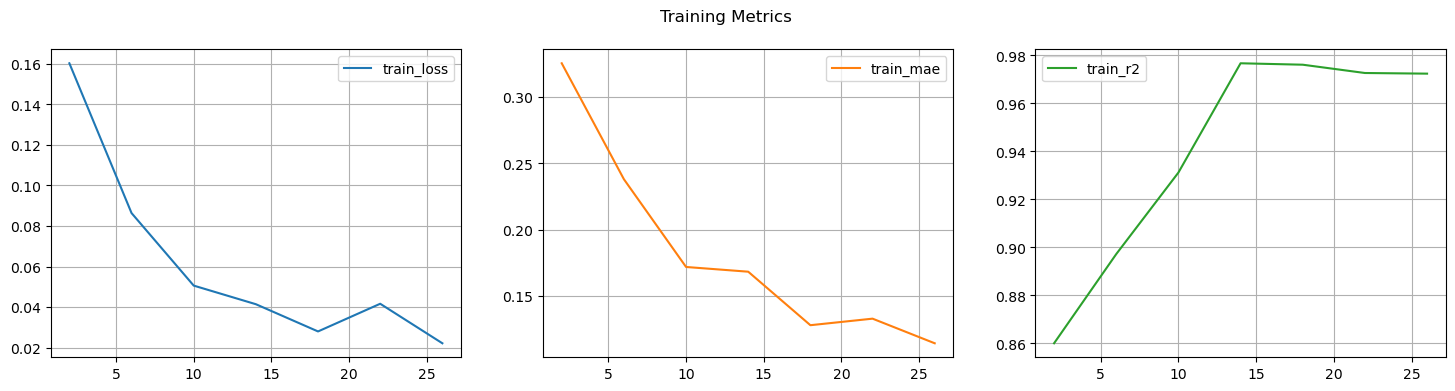

In [42]:
log_file[['train_loss', 'train_mae', 'train_r2']].dropna().plot(
    subplots=True, layout=(1, 3), figsize=(18, 4), grid=True, title="Training Metrics"
)

array([[<Axes: >, <Axes: >, <Axes: >]], dtype=object)

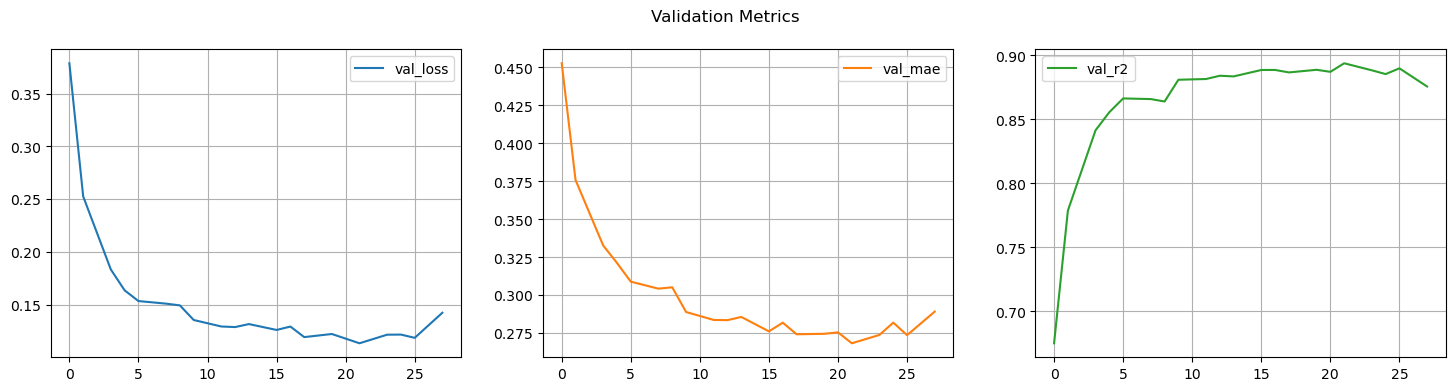

In [43]:
log_file[['val_loss', 'val_mae', 'val_r2']].dropna().plot(
    subplots=True, layout=(1, 3), figsize=(18, 4), grid=True, title="Validation Metrics"
)

#### Evaluate Model

In [44]:
trainer.test(model=fc_obesity_model, dataloaders=test_loader)

/Users/Daxtonfurniss_1/opt/anaconda3/envs/dl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 159.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.12349916994571686
        test_mae            0.2816437780857086
     test_mae_epoch         0.2816437780857086
         test_r2            0.8453882932662964
      test_r2_epoch         0.8726938366889954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.12349916994571686,
  'test_mae': 0.2816437780857086,
  'test_r2': 0.8453882932662964,
  'test_mae_epoch': 0.2816437780857086,
  'test_r2_epoch': 0.8726938366889954}]